In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy

# Téma: Monte Carlo, importance sampling, particle filtry

## Bayesovská filtrace stavových modelů

Vraťme se ještě jednou ke stavovým modelům ve tvaru

$$
\begin{aligned}
x_t &= A x_{t-1} + B u_t + w_t, \\
y_t &= H x_t + \epsilon_t,
\end{aligned}
$$

kde obě šumové proměnné budiž nezávislé normální a centrované v nule

$$
\begin{aligned}
w_t &\sim \mathcal{N}(0, Q),\\
\epsilon_t &\sim \mathcal{N}(0, R).
\end{aligned}
$$

Nyní jsme zavedli předpoklad normality šumů na stavech i na pozorováních. Potom tedy můžeme psát

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q) \qquad\text{s hustotou}\quad f(x_t|x_{t-1}, u_t) \\
y_t &\sim \mathcal{N}(Hx_{t}, R) \qquad\qquad\quad \text{s hustotou}\quad h(y_t|x_t).
\end{aligned}
$$

Pokud jsme k odhadu používali UT transformaci, reprezentovali jsme znalost o odhadované veličině pomocí několika málo sigma bodů. Nyní předpokládejme, že použijeme bodů výrazně více a náhodně vybraných. Nepůjde tedy o sigma body, ale Monte Carlo vzorky - particly.

Particly reprezentují apriorní distribuci - neupdatovanou znalost - $x_t$. Jde nám o Bayesovský odhad. Jelikož model $y_t$ je (aspoň přibližně) normální, konjugované apriorno bude tedy rovněž normální se střední hodnotou označenou $x_{t-1}^{+}$ a kovarianční maticí $P_{t-1}^{+}$,

$$
\pi(x_t|y_{0:t-1}, u_{0:t-1}) = \mathcal{N}(x_{t-1}^{+}, P_{t-1}^{+}).
$$

Vzpomeňme, že Kalmanův filtr běží ve dvou krocích - **predikce stavu** a **korekce** (též update).

### Predikce

$$
\pi(x_{t}|y_{0:t-1}, u_{0:t})
= \int f(x_{t}|x_{t-1}, u_{t})\, \pi(x_{t-1}|y_{0:t-1}, u_{0:t-1}) dx_{t-1}.
$$

Jelikož násobíme dvě normální distribuce a marginalizujeme, dostaneme opět normální distribuci
$\mathcal{N}(x_{t}^{-}, P_{t}^{-})$ s hyperparametry

$$
\begin{aligned}
    x_{t}^{-} &= A x_{t-1}^{+} + B u_{t}, \\
    P_{t}^{-} &= A P_{t-1}^{+} A^{\intercal} + Q.
\end{aligned}
$$

Vidíme, že násobení dvou normálních distribucí a následná marginalizace vlastně jen vyčíslí rovnici pro stav.

### Korekce

Korekce je jen využití Bayesovy věty z NI-BML nebo BI-PST:

$$
\pi(x_{t}|y_{0:t}, u_{0:t}) 
\propto
h(y_{t}|x_{t})\,
\pi(x_{t}|y_{0:t-1}, u_{0:t}) 
$$

Kdybychom do rovnic dosadili (viz NI-BML), dostali bychom rovnice Kalmanova filtru, který už známe. Aneb jiná cesta k témuž :)

## První krok k Monte Carlo metodám - empirická distribuce

V UT jsme měli vzorků málo a šlo nám o to, aby jejich průměr a výběrová kovariance byly ideálně rovny střední hodnotě a kovarianci odhadované veličiny. V particle filtraci vzorky vybíráme z vybrané - zde apriorní - distribuce $\pi(x_t|y_{0:t-1}, u_{0:t-1})$, kterou pomocí nich reprezentujeme. Stejně pak budeme reprezentovat i aposteriorní a každou jinou, distribuci.

Pokud máme vzorky $\{x^{(i)}\}_{i=1}^N = \{x^{(1)}, \ldots, x^{(N)}\}$, můžeme mluvit o empirické distribuci ve tvaru

$$
\tilde{\pi}^N(x) = \frac{1}{N} \sum_{i=1}^N \delta_{x^{(i)}}(x).
$$

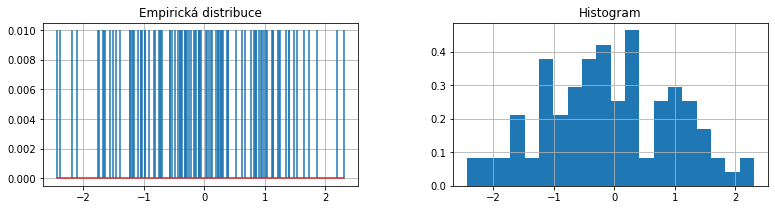

In [8]:
x = norm.rvs(size=100)
plt.figure(figsize=(13,3))
plt.subplot(121)
plt.title('Empirická distribuce')
plt.stem(x, np.ones_like(x)/x.size, markerfmt=' ', use_line_collection=True)
plt.subplot(122)
plt.title('Histogram')
plt.hist(x, bins=20, density=True)
plt.show()

Pokud jsou k $x_i$ přiřazeny váhy, které charakterizují míru jejich pravděpodobnosti, tj. máme dvojice $\{x^{(i)}, w^{(i)}\}_{i=1}^N$, můžeme mluvit o empirické distribuci ve tvaru

$$
\pi^N(x) = \frac{\sum_{i=1}^N w^{(i)} \delta_{x^{(i)}}(x)}{\sum_{i=1}^N w_i},
$$

přičemž můžeme normalizaci (viz jmenovatel) provést rovnou,

$$
W_i = \frac{w^{(i)}}{\sum_{i=1}^N w^{(i)}}.
$$

Pak lze pro libovolnou funkci $F(x)$ psát např.

$$
\int F(x)\pi(x)dx \approx \int F(x) \pi^N(x) dx,
$$

kde $\pi^N(x)$ je empirická distribuce ze vzorků $x^{(i)} \sim \pi(x)$.

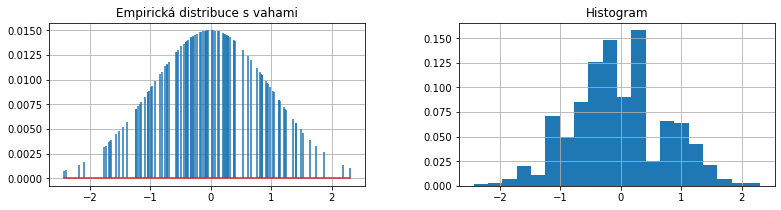

In [9]:
wx = norm.pdf(x)
wx /= wx.sum()
plt.figure(figsize=(13,3))
plt.subplot(121)
plt.stem(x, wx, markerfmt=' ', use_line_collection=True)
plt.title('Empirická distribuce s vahami')
plt.subplot(122)
plt.hist(x, weights=wx, bins=20)
plt.title('Histogram')
plt.show()

## Sequential Importance Sampling (SIS)

Vraťme se nyní k problematice stavových modelů ve tvaru

$$
\begin{aligned}
x_t &\sim f_t(x_t|x_{t-1}, u_t), \\
y_t &\sim h_t(y_t|x_t),
\end{aligned}
$$

kde $x_t$ je nepozorovatelný stav systému, $f_t(x_t|x_{t-1}, u_t)$ je model vývoje v podobě nějaké vhodné hustoty pravděpodobnosti, $y_t$ jsou pozorování (též měření) a $h(y_t|x_t)$ je model pozorování, rovněž v podobě nějaké vhodné hustoty. Pokud oba modely jsou lineární a příslušné funkce jsou hustoty normálního rozdělení, víme z dřívějších přednášek, že sekvenční odhad pro $t=1, 2, \ldots$ poskytne např. Kalmanův filtr.

Připomeňme, co zaznělo výše, že lineární je např. takovýto "klasický" model:

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q) \qquad\text{s hustotou}\quad f(x_t|x_{t-1}, u_t) \\
y_t &\sim \mathcal{N}(Hx_{t}, R) \qquad\qquad\quad \text{s hustotou}\quad h(y_t|x_t).
\end{aligned}
$$

A když linerita splněna není, můžeme zkusit EKF nebo UKF. A pokud je nelinerita silná, je velmi vhodné využít právě **importance sampling**. Pro jeho výklad zavedeme následující zjednodušení v notaci, která jsou bez újmy na obecnosti a jejich cílem je jen trochu zpřehlednit zápis:
- vypustíme $u_t$ (stejně je to deterministická veličina)
- vypustíme časový index u hustot $f$ a $g$.

Stejně jako v případě Kalmanova filtru (a všech bayesovských odhadů) začneme od vhodně zvolené apriorní hustoty, kterou zde ale **navzorkujeme** do podoby empirické distribuce reprezentované vzorky $\{x_{0:t-1}^{(i)}, w_{t-1}^{(i)}\}_{i=1}^N$,

$$
\pi(x_{0:t-1}|y_{0:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{0:t-1}^{(i)}}(x_{0:t-1}).
$$

Stejně jako v případě základního Kalmanova filtru poběží základní SIS filtr ve dvou krocích - predikce a update.

### Predikce
Predikce udává časový vývoj stavů z $x_{t-1}$ na $x_t$ podle příslušného modelu. Použijeme tedy apriorní distribuci a přenásobíme ji modelem,

$$
\pi(x_{0:t}|y_{0:t-1}) = \pi(x_{0:t-1}|y_{0:t-1}) \cdot f(x_t|x_{t-1}).
$$

V SIS filtru to znamená, že vzorky "proženeme" modelem v podobě samplování z modelu, do něhož vložíme vzorky předchozí,

$$
x_t^{(i)} \sim f(x_t|x_{t-1}^{(i)}).
$$

Tím dostaneme novou empirickou distribuci

$$
\pi(x_{0:t}|y_{0:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{0:t}^{(i)}}(x_{0:t}).
$$

### Update
Update využije Bayesovu větu - vloží do hustoty stavů nová pozorování (měření). Aplikuje ji na empirickou distribuci z predikce,

$$
\begin{aligned}
\pi(x_{0:t}|y_{0:t})
&\propto \pi(x_{0:t}|y_{0:t-1}) \cdot h(y_t|x_t) \\[2mm]
&\approx \frac{\sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{0:t}^{(i)}}(x_{0:t}) \cdot h(y_t|x_t^{(i)})}{\sum_{i=1}^N w_{t-1}^{(i)}(x_{0:t}) \cdot h(y_t|x_t^{(i)})} \\[2mm]
&\propto \sum_{i=1}^N w_t^{(i)} \delta_{x_{0:t}^{(i)}}(x_{0:t}).
\end{aligned}
$$

Tedy

$$
w_t^{(i)} = w_{t-1}^{(i)} h(y_t|x_t^{(i)})
$$

následované normalizací
$$
w_t^{(i)} \leftarrow \frac{w_t^{(i)}}{\sum_{j=1}^N w_t^{(j)}}.
$$

### Poznámka

Výše uvedený update vede po přidání *resamplingu* - viz níže - na tzv. *bootstrap particle filter*. Obecnější přístup se opírá, podobně jako v IS, o proposal distribuci $q(x_t|x_{t-1}, y_t)$ a updatuje váhy

$$
w_t^{(i)} \propto w_{t-1}^{(i)} \frac{h(y_t|x_t^{(i)}) f(x_{t}|x_{t-1})}{q(x_{t}|x_{t-1}, y_t)}.
$$

Uvedenou variantu dostaneme pokud za proposal použijeme model stavů,

$$
q(x_{t}|x_{t-1}, y_t) \equiv f(x_t|x_{t-1}).
$$

To s sebou nese značné zjednodušení výpočtů, ovšem existují mnohem lepší proposal distribuce.

### Algoritmus SIS filtru
   1. Navzorkujeme $x_0^{(i)}$ z vhodné apriorní distribuce $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. Pro $t=1,2,\ldots$:
       - Predikce: navzorkujeme nová $x_t^{(i)}$ z hustoty $f(x_t|x_{t-1}^{(i)})$.
       - Update: přepočítáme váhy $w_t^{(i)} = w_{t-1}^{(i)} h(y_t|x_t^{(i)})$ a normalizujeme je $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Odhad střední hodnoty $\hat{x}_t = \sum_i w_{t}^{(i)} x_t^{(i)}$.
       - Odhad kovariance odhadu $P_t = \sum_i w_t^{(i)}\left[x_t^{(i)}x_t^{(i),\intercal}\right] - \hat{x}_t \hat{x}_t^\intercal$.

### Příklad

Uvažujme pro jednoduchost lineární model

$$
\begin{align}
x_t &= 0.9 x_{t-1} + 0.7 + w_t \\
y_t &= 0.5 x_t + \epsilon_t
\end{align}
$$

kde $x_1$ = 1 a

$$
w_t \sim \mathcal{N}(0, 0.2^2), \qquad \varepsilon_t \sim \mathcal{N}(0, 0.2^2).
$$

Jako proposal distribuci použijeme $\mathcal{N}(0, 1)$.

Velmi jednoduchý nepříliš optimální kód může vypadat takto:

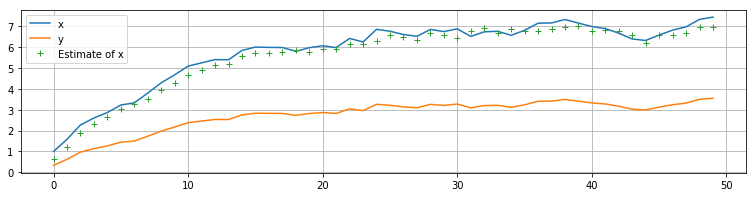

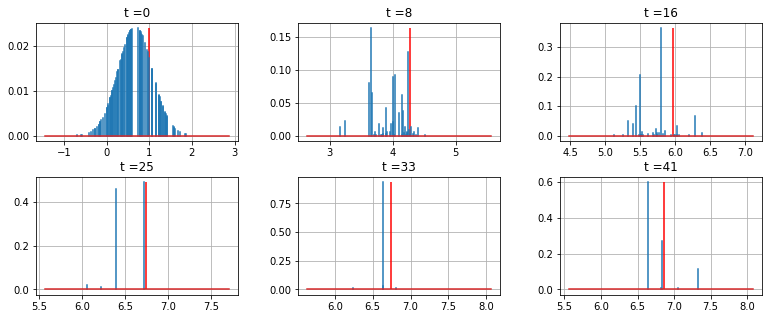

In [27]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

V obrázcích výše vidíme několik zajímavostí. Jednak vývoj stavu $x_t$, jeho odhadu a vývoj pozorování $y_t$. Na 6 malých obrázcích potom vývoj vah pro různé vzorky. Připomeňme, že vzorků je `nsamples`, ale váhy se postupně zkoncentrují na několika málo vzorcích. A co hůř, postupně by celý filtr s rostoucím $t$ zdegeneroval do jediného vzorku! Jak se tento problém řeší se dozvíme u SIR filtru.

Co by šlo dále vylepšit? Předně, výpočet vah jak je uveden výše není numericky stabilní - inkrementální váhy jsou totiž velmi blízké nule a hrozí, že na numerice se po násobení projeví právě tou nulou. To se elegantně řeší počítáním v logaritmech.

## Sequential importance resampling (SIR) - particle filter

V příkladu výše je patrné, jak váhy degenerují a nakonec by jeden vzorek měl váhu limitně rovnu 1 a ostatní 0. To vede ke kolapsu filtru, neboť update vah je postaven na násobení inkrementální vahou - a co je blízké nule se při násobení moc nezmění.

Jedním z nejpopulárnějších řešení probému degenerace je **resampling**. Ten, zjednodušeně řečeno, vybere úspěšnější vzorky (s vyššími vahami) a zreplikuje je. Naopak vzorky s nižšími vahami jsou s vysokou pravděpodobností zahozeny. 

Nejzákladnější metoda provádní výběr $N$ vzorků s opakováním z množiny $\{x_{t-1}^{(i)}, w_t^{(i)}\}_{i=1}^N$, přičemž pravděpodobnost výběru $x_{t-1}^{(i)}$ je proporcionální k jeho váze $w_{t-1}^{(i)}$. Vzorky s vyššími vahami jsou tedy pravděpodobně vybrány vícekrát a naopak. Jejich rozprostření následně obstará model vývoje. Váhy jsou srovnány na $1/N$ pro všechny vzorky.

### Algoritmus bootstrap particle filtru
   1. Navzorkujeme $x_0^{(i)}$ z vhodné apriorní distribuce $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. Pro $t=1,2,\ldots$:
       - Resampling: vybereme $\tilde{x}_{t-1}^{(i)}\sim \sum_{i=1}^N w_{t-1}^{(i)} x_{t-1}^{(i)}$ proporcionálně k jejich vahám $w_{t-1}^{(i)}$, nastavíme všem vzorkům váhy $1/N$.
       - Predikce: navzorkujeme nová $x_t^{(i)}$ z hustoty $f(x_t|\tilde x_{t-1}^{(i)})$.
       - Update: přepočítáme váhy $w_t^{(i)} = w_{t-1}^{(i)} h(y_t|x_t^{(i)})$ a normalizujeme je $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Odhad střední hodnoty $\hat{x}_t = \sum_i w_{t}^{(i)} x_t^{(i)}$.
       - Odhad kovariance odhadu $P_t = \sum_i w_t^{(i)}\left[x_t^{(i)}x_t^{(i),\intercal}\right] - \hat{x}_t \hat{x}_t^\intercal$.
       
Jak je patrné, oproti SIS filtru přibyl jediný krok, a sice zmíněný (zde multinomický) resampling. Existuje více možností, jak se k resamplingu postavit:
   - resamplovat každé $t$, nebo jen tehdy, když je to "nějak" výhodnější.
   - využít různé resamplovací algoritmy - stratifikovaný resampling aj.

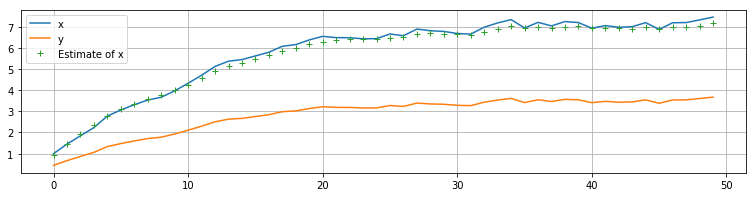

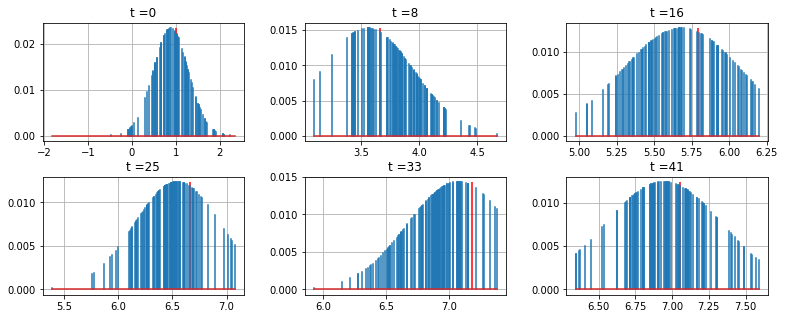

In [6]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

def resample(x, weights):
    xnew = np.random.choice(x, replace=True, p=weights, size=weights.size)
    weights = np.ones_like(weights)/weights.size
    return [xnew, weights]

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.vlines(x[row], 0, weights_log[row].max(), color='red')
    plt.title('t ={0}'.format(row))

## Další možnosti particle filtrace

Co můžeme zlepšit na filtraci pomocí vzorků ze stavového prostoru? Z těch základních možností jmenujme hlavně:
   - marginalizované particle filtry - je-li část modelu lineární, lze ji počítat analyticky a zbytek Monte Carlo metodami.
   - Auxiliary particle filter - jiný přístup k PF.
   - Approximate Bayesian filter - pokud model pozorování $h()$ není hustota pravděpodobnosti, nebo je příliš komplikovaná na výpočet.
   - a spousty dalšího...